In [ ]:
# ======= Variables =========

# Fill in the variables below and run cell first
# Note: Use forward slashes / instead of backslashes \ in file paths

DATASET_FOR_MODEL_CSV_FILE_PATH = 'C:/cal-housing-prices/dataset/dataset.csv'

TRAINING_SET_CSV_FILE_PATH = 'C:/cal-housing-prices/dataset/training_set.csv'
TEST_SET_CSV_FILE_PATH = 'C:/cal-housing-prices/dataset/test_set.csv'
TEST_SET_SIZE = 0.1  # fraction of the dataset to be used as test set

MODEL_FOLDER_PATH = 'C:/cal-housing-prices/models/'

RANDOM_SEED = 123


In [107]:
# ========= Libraries =========

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset

## ML

In [135]:
# ========= CustomDataset class =========

torch.manual_seed(RANDOM_SEED)  # Set the random seed in PyTorch for reproducibility

class CustomDataset(Dataset):
    """
    A custom dataset class for handling data directly from a pandas dataframe.

    """
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        # Assuming the last column is the output/target
        data = torch.tensor(row[:-1].values, dtype=torch.float32)
        target = torch.tensor(row[-1], dtype=torch.float32)
        return data, target
    

class CustomDatasetAutoencoder(Dataset):
    """
    A custom dataset class for handling data directly from a pandas dataframe.
    To be used in autoencoder models where the input and output are the same.

    """
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        data = torch.tensor(row.values, dtype=torch.float32)
        target = data.clone() # Autoencoder output is the same as the input. Clone the data to have different memory reference.
        return data, target


In [109]:
# ========= Create Training and Test sets =========

# Load dataset into a pandas DataFrame
df = pd.read_csv(DATASET_FOR_MODEL_CSV_FILE_PATH)

# Separate a Test set and keep it aside
dfTest = df.sample(frac=TEST_SET_SIZE, axis='index', random_state=RANDOM_SEED) # random_state parameter is included for reproducibility
df = df.drop(dfTest.index) # the remaining data is used as the training set

# Save the Training and Test sets to CSV files
df.to_csv(TRAINING_SET_CSV_FILE_PATH, index=False)
dfTest.to_csv(TEST_SET_CSV_FILE_PATH, index=False)

In [ ]:
# ========= Neural Network and Training classes =========

class SimpleNN(torch.nn.Module):
    def __init__(self, input_size=3, output_size=1, neurons=10):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, neurons)
        # self.fc1a = torch.nn.Linear(neurons, neurons) # add another layer
        # self.fc1b = torch.nn.Linear(neurons, neurons) # add another layer
        self.fc2 = torch.nn.Linear(neurons, output_size)

    def forward(self, x):
        # print("input: ", x.shape)
        x = self.fc1(x)
        # x = torch.nn.functional.relu(x)
        # x = self.fc1a(x)  # add another layer
        x = torch.nn.functional.relu(x) 
        # x = self.fc1b(x)  # add another layer
        # x = torch.nn.functional.relu(x) 
        x = self.fc2(x)
        # print("output: ", x.shape)
        return x
    
class NeuralNetworkRegressor:
    def __init__(self, input_size=5, output_size=1, neurons=10, learning_rate=0.001, batch_size=32, epochs=100):
        self.norm_params = {}
        self.model = SimpleNN(input_size=input_size, output_size=output_size, neurons=neurons)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = torch.device("cpu")
        self.model.to(self.device)
        self.loss_function = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

    def normalize(self, dataframe, train=False):
        # Min-Max Normalization
        for column in dataframe.columns:
            min_value = dataframe[column].min() if train else self.norm_params[column][0]
            max_value = dataframe[column].max() if train else self.norm_params[column][1]
            if train:
                self.norm_params[column] = (min_value, max_value)
            dataframe[column] = (dataframe[column] - min_value) / (max_value - min_value)
        return dataframe
    
    def denormalize(self, dataframe):
        # Min-Max De-normalization
        for column in dataframe.columns:
            min_value, max_value = self.norm_params[column]
            dataframe[column] = dataframe[column] * (max_value - min_value) + min_value
        return dataframe

    def train(self, dataframe):

        dataframe = self.normalize(dataframe.copy(), train=True)
        dataset = CustomDataset(dataframe)
        train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0

            for data, target in train_loader:

                data, target = data.to(self.device), target.to(self.device)
                # print(data.shape, target.shape)
                
                self.model.zero_grad()
                output = self.model(data)
                loss = self.loss_function(output, target.view(-1, 1))
                
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()

            print(f"Epoch: {epoch + 1}, Loss: {total_loss}")

    def predict(self, dataframe):
        # assume the last column in the dataframe is the target initialized to 0 and will be replaced by the prediction
        dataframe = self.normalize(dataframe, train=False)
        dataset = CustomDataset(dataframe)

        self.model.eval()

        for i in range(len(dataset)):
            data, _ = dataset[i]
            data = data.to(self.device)
            output = self.model(data)
            dataframe.iloc[i, -1] = output.item()

        dataframe = self.denormalize(dataframe)
        return dataframe




class SimpleNNAutoencoder(torch.nn.Module):
    def __init__(self, input_size=3, neurons=10):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, neurons)
        self.fc2 = torch.nn.Linear(neurons, 1)
        self.fc3 = torch.nn.Linear(1, neurons)
        self.fc4 = torch.nn.Linear(neurons, input_size)

    def forward(self, x):
        # print("input: ", x.shape)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        compressed_output = self.fc2(x)
        x = torch.nn.functional.relu(compressed_output)
        x = self.fc3(x)
        x = torch.nn.functional.relu(x)
        x = self.fc4(x)
        # print("output: ", x.shape)
        return x, compressed_output
    
class NeuralNetworkRegressorAutoencoder:
    def __init__(self, input_size=5, neurons=10, learning_rate=0.001, batch_size=32, epochs=100):
        self.norm_params = {}
        self.model = SimpleNNAutoencoder(input_size=input_size, neurons=neurons)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = torch.device("cpu")
        self.model.to(self.device)
        self.loss_function = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

    def normalize(self, dataframe, train=False):
        # Min-Max Normalization
        for column in dataframe.columns:
            min_value = dataframe[column].min() if train else self.norm_params[column][0]
            max_value = dataframe[column].max() if train else self.norm_params[column][1]
            if train:
                self.norm_params[column] = (min_value, max_value)
            dataframe[column] = (dataframe[column] - min_value) / (max_value - min_value)
        return dataframe
    
    def denormalize(self, dataframe):
        # Min-Max De-normalization
        for column in dataframe.columns:
            min_value, max_value = self.norm_params[column]
            dataframe[column] = dataframe[column] * (max_value - min_value) + min_value
        return dataframe

    def train(self, dataframe):

        dataframe = self.normalize(dataframe.copy(), train=True)
        dataset = CustomDatasetAutoencoder(dataframe)
        train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0

            for data, target in train_loader:

                data, target = data.to(self.device), target.to(self.device)
                # print(data.shape, target.shape)
                
                self.model.zero_grad()
                output, compressed_output = self.model(data) # only the final output is used for training
                loss = self.loss_function(output, target)
                
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()

            print(f"Epoch: {epoch + 1}, Loss: {total_loss}")

    def predict(self, dataframe):
        # add a column to the dataframe to store the autoencoder output. Only output the autoencoder compressed output

        dataframeOutput = dataframe.copy()

        dataframe = self.normalize(dataframe, train=False)
        dataset = CustomDatasetAutoencoder(dataframe)

        self.model.eval()

        for i in range(len(dataset)):
            data, _ = dataset[i]
            data = data.to(self.device)
            output, compressed_output = self.model(data)

            # Save compressed output to return
            # TODO: Remove hardcoded value
            dataframeOutput.at[i, 'autoencoder_output'] = compressed_output.item()

            # Save the reconstructed output of each column as well to return
            for j, column in enumerate(dataframe.columns):
                dataframeOutput.at[i, column] = output[j].item() 

        # Denormalize the dataframe input because it is passed by reference
        dataframe = self.denormalize(dataframe)

        # Denormalize only the re-constructed columns in the prediction dataframe
        columns = dataframe.columns
        dataframeOutput[columns] = self.denormalize(dataframeOutput[columns])

        return dataframeOutput

## Train Model

In [402]:
# ========= Load Training and Test sets =========

# Load the Training set into a pandas dataframe
dfTraining = pd.read_csv(TRAINING_SET_CSV_FILE_PATH)

# Load the Test set into a pandas dataframe
dfTest = pd.read_csv(TEST_SET_CSV_FILE_PATH)


# Autoencoder for location data
dfTrainingLocation = dfTraining[['longitude', 'latitude', 'ocean_proximity_category']]
dfTestLocation = dfTest[['longitude', 'latitude', 'ocean_proximity_category']]

########################
# drop latitude and longitude

# dfTraining = dfTraining.drop(columns=['latitude', 'longitude'])

# dfTraining = dfTraining[['longitude', 'latitude', 'ocean_proximity_category']]


In [ ]:
# Create location feature from autoencoder and add to both Training and Test sets

# Get the compressed location feature from the autoencoder
dfPredictLocationTraining = modelAutoencoderLocation.predict(dfTrainingLocation)
dfPredictLocationTest = modelAutoencoderLocation.predict(dfTestLocation)

locationColumnTraining = dfPredictLocationTraining['autoencoder_output']
locationColumnTest = dfPredictLocationTest['autoencoder_output']

# Drop the original location columns and add the compressed location feature
dfTraining = dfTraining.drop(columns=['longitude', 'latitude', 'ocean_proximity_category'])
dfTest = dfTest.drop(columns=['longitude', 'latitude', 'ocean_proximity_category'])

dfTraining['location'] = locationColumnTraining
dfTest['location'] = locationColumnTest

# Bring the median_house_value column to the end, since it is the target
dfTraining = dfTraining[[column for column in dfTraining if column != 'median_house_value'] + ['median_house_value']]
dfTest = dfTest[[column for column in dfTest if column != 'median_house_value'] + ['median_house_value']]

In [433]:
# keep only median_house_value below 100000

dfTraining = dfTraining[dfTraining['median_house_value'] < 100000]
dfTest = dfTest[dfTest['median_house_value'] < 100000]

In [434]:
dfTraining

,housing_median_age,households,median_income,location,median_house_value
23,49.0,239.0,24597.0,2.469013,93800.0
32,49.0,264.0,14861.0,2.464979,97200.0
48,43.0,407.0,15045.0,2.463278,93800.0
49,41.0,720.0,11108.0,2.463278,97500.0
51,52.0,233.0,16098.0,2.463918,87500.0
...,...,...,...,...,...
17492,25.0,330.0,15603.0,0.044273,78100.0
17493,18.0,114.0,25568.0,0.043267,77100.0
17494,17.0,433.0,17000.0,0.044038,92300.0
17495,18.0,349.0,18672.0,0.043279,84700.0


In [ ]:
# Train the autoencoder for location data

modelAutoencoderLocation = NeuralNetworkRegressorAutoencoder(input_size=3, neurons=1000, learning_rate=0.0001, batch_size=256, epochs=500)

modelAutoencoderLocation.train(dfTrainingLocation)

Epoch: 1, Loss: 4.492151785641909
Epoch: 2, Loss: 1.7234023995697498
Epoch: 3, Loss: 1.326044026762247
Epoch: 4, Loss: 1.0577102536335588
Epoch: 5, Loss: 0.9479911737143993
Epoch: 6, Loss: 0.8920174464583397
Epoch: 7, Loss: 0.8375240005552769
Epoch: 8, Loss: 0.7991767008788884
Epoch: 9, Loss: 0.7725208778865635
Epoch: 10, Loss: 0.7450000522658229
Epoch: 11, Loss: 0.719624474644661
Epoch: 12, Loss: 0.7002298068255186
Epoch: 13, Loss: 0.6780674937181175
Epoch: 14, Loss: 0.6608247915282845
Epoch: 15, Loss: 0.6464389660395682
Epoch: 16, Loss: 0.6310380944050848
Epoch: 17, Loss: 0.619407111313194
Epoch: 18, Loss: 0.6019343957304955
Epoch: 19, Loss: 0.5857171448878944
Epoch: 20, Loss: 0.5708181643858552
Epoch: 21, Loss: 0.5578075340017676
Epoch: 22, Loss: 0.5387669075280428
Epoch: 23, Loss: 0.5258522541262209
Epoch: 24, Loss: 0.5055423909798265
Epoch: 25, Loss: 0.48383159236982465
Epoch: 26, Loss: 0.4632769599556923
Epoch: 27, Loss: 0.44452666491270065
Epoch: 28, Loss: 0.4216039238963276
Epo

C:\Users\stavr\AppData\Local\Temp\ipykernel_67784\3350613062.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column] = (dataframe[column] - min_value) / (max_value - min_value)
C:\Users\stavr\AppData\Local\Temp\ipykernel_67784\3350613062.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column] = dataframe[column] * (max_value - min_value) + min_value


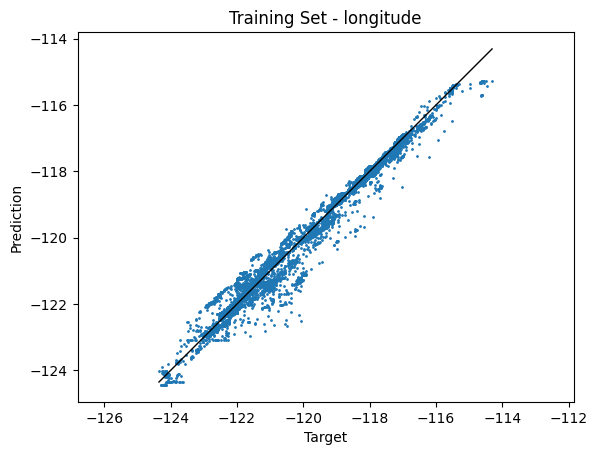

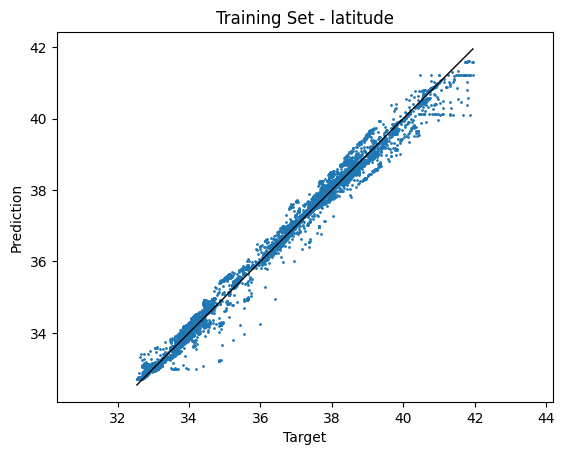

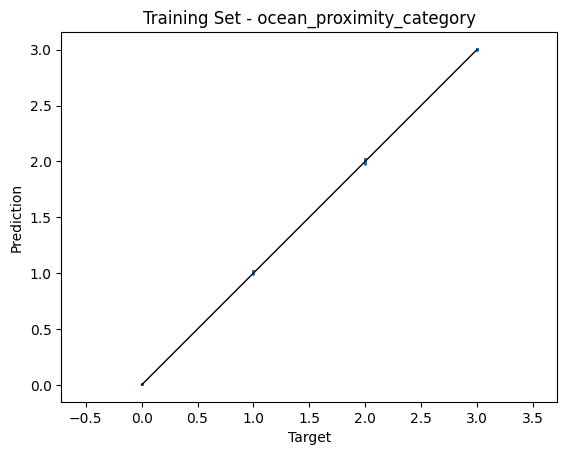

In [389]:
# Autoencoder model prediction - Training Set

import matplotlib.pyplot as plt

dfPredict = modelAutoencoderLocation.predict(dfTrainingLocation)

# plot the test target vs prediction in scatter plot. also plot the y = x line
for i, column in enumerate(dfTrainingLocation.columns):
    plt.figure()
    plt.scatter(dfTrainingLocation.iloc[:,i], dfPredict.iloc[:,i], s=1, marker='o')
    plt.plot([dfTrainingLocation.iloc[:,i].min(), dfTrainingLocation.iloc[:,i].max()], [dfTrainingLocation.iloc[:,i].min(), dfTrainingLocation.iloc[:,i].max()], color='black', linewidth=1)
    plt.axis('equal')  # Make the axes have the same scale
    plt.title("Training Set - " + column)
    plt.xlabel("Target")
    plt.ylabel("Prediction")
    plt.show()


C:\Users\stavr\AppData\Local\Temp\ipykernel_67784\3350613062.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column] = (dataframe[column] - min_value) / (max_value - min_value)
C:\Users\stavr\AppData\Local\Temp\ipykernel_67784\3350613062.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column] = dataframe[column] * (max_value - min_value) + min_value


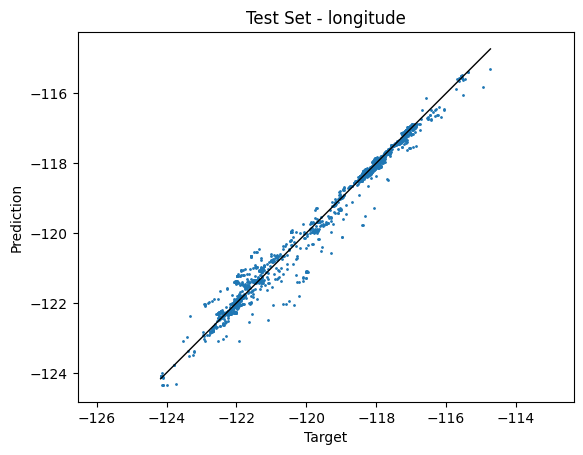

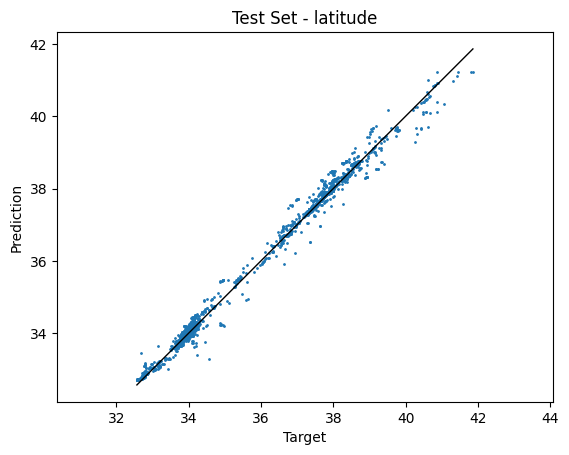

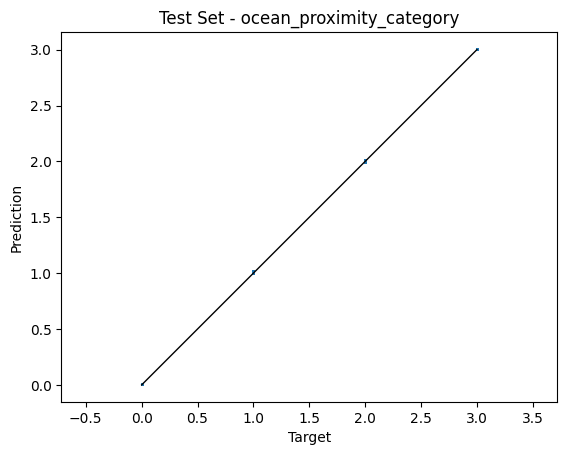

In [393]:
# Autoencoder model prediction - Test Set

import matplotlib.pyplot as plt

dfPredict = modelAutoencoderLocation.predict(dfTestLocation)

# plot the test target vs prediction in scatter plot. also plot the y = x line
for i, column in enumerate(dfTestLocation.columns):
    plt.figure()
    plt.scatter(dfTestLocation.iloc[:,i], dfPredict.iloc[:,i], s=1, marker='o')
    plt.plot([dfTestLocation.iloc[:,i].min(), dfTestLocation.iloc[:,i].max()], [dfTestLocation.iloc[:,i].min(), dfTestLocation.iloc[:,i].max()], color='black', linewidth=1)
    plt.axis('equal')  # Make the axes have the same scale
    plt.title("Test Set - " + column)
    plt.xlabel("Target")
    plt.ylabel("Prediction")
    plt.show()

In [395]:
dfTestLocation

,longitude,latitude,ocean_proximity_category
0,-122.91,39.17,0.0
1,-117.08,32.61,2.0
2,-118.00,33.93,1.0
3,-117.72,34.10,0.0
4,-117.22,32.84,2.0
...,...,...,...
1939,-121.87,37.27,1.0
1940,-121.82,39.73,0.0
1941,-119.66,36.33,0.0
1942,-122.65,38.27,1.0


In [394]:
dfPredict

,longitude,latitude,ocean_proximity_category,autoencoder_output
0,-122.078351,39.716964,0.008363,0.032390
1,-116.968677,32.727956,1.999286,1.134403
2,-118.069272,33.898785,1.005593,0.902163
3,-117.689619,34.303454,0.006371,0.161603
4,-117.168641,32.875826,2.003577,1.146604
...,...,...,...,...
1939,-121.825929,37.323319,1.006656,0.688652
1940,-122.036989,39.656429,0.008277,0.033704
1941,-119.678703,36.415309,0.007350,0.105990
1942,-122.696420,38.240200,1.008107,0.635407


In [ ]:
# ========= Training =========

model = NeuralNetworkRegressor(input_size=4, output_size=1, neurons=1000, learning_rate=0.001, batch_size=256, epochs=100)

model.train(dfTraining)

In [425]:
dfTraining

,housing_median_age,households,median_income,location,median_house_value
0,41.0,126.0,83252.0,2.470918,452600.0
1,21.0,1138.0,83014.0,2.466878,358500.0
2,52.0,177.0,72574.0,2.466458,352100.0
3,52.0,219.0,56431.0,2.467098,341300.0
4,52.0,259.0,38462.0,2.467098,342200.0
...,...,...,...,...,...
17492,25.0,330.0,15603.0,0.044273,78100.0
17493,18.0,114.0,25568.0,0.043267,77100.0
17494,17.0,433.0,17000.0,0.044038,92300.0
17495,18.0,349.0,18672.0,0.043279,84700.0


## Training Set Prediction

In [ ]:
import matplotlib.pyplot as plt

# make a copy of dfTraining to keep the original data
dfPredict = dfTraining.copy()

model.predict(dfPredict)

# plot the test target vs prediction in scatter plot. also plot the y = x line
plt.scatter(dfTraining.iloc[:,-1], dfPredict.iloc[:,-1], s=1, marker='o')
plt.plot([0, dfTraining.iloc[:,-1].max()], [0, dfTraining.iloc[:,-1].max()], color='black', linewidth=1)
plt.axis('equal')  # Make the axes have the same scale
plt.title("Training Set")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.show()

## Test Set Prediction

C:\Users\stavr\AppData\Local\Temp\ipykernel_67784\3403912270.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target = torch.tensor(row[-1], dtype=torch.float32)


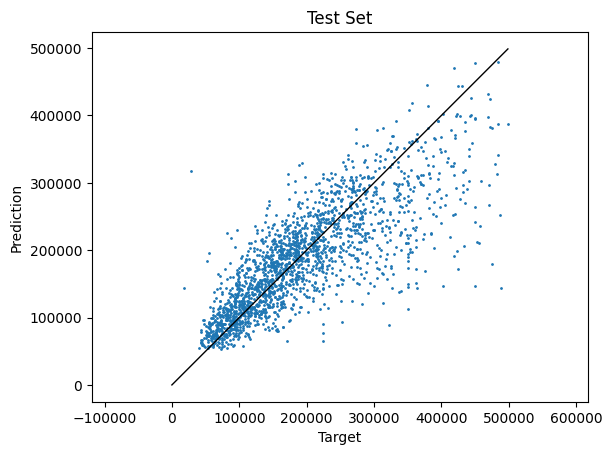

In [427]:
import matplotlib.pyplot as plt

# make a copy of dfTest to keep the original data
dfTestPredict = dfTest.copy()

model.predict(dfTestPredict)

# plot the test target vs prediction in scatter plot. also plot the y = x line
plt.scatter(dfTest.iloc[:,-1], dfTestPredict.iloc[:,-1], s=1, marker='o')
plt.plot([0, dfTest.iloc[:,-1].max()], [0, dfTest.iloc[:,-1].max()], color='black', linewidth=1)
# plt.xlim(left=0)
# plt.ylim(bottom=0) 
plt.axis('equal')  # Make the axes have the same scale
plt.title("Test Set")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.show()

## Save / Load Models

In [320]:
# =============== Functions to Save and Load models ===============

def save_model(model, folderPath='.', fileName='model'):
    """Save the trained model to a file"""
    if folderPath.endswith("/") or folderPath.endswith("\\"):
        folderPath = folderPath[:-1]

    try:
        filePath = f"{folderPath}/{getCurrentTimestampString()}_{fileName}.pt"
        torch.save(model, filePath)
        print(f"Model saved to: {filePath}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False


def load_model(folderPath='.', fileName='model'):
    """Load a trained model from a file"""
    if folderPath.endswith("/") or folderPath.endswith("\\"):
        folderPath = folderPath[:-1]

    try:
        filePath = f"{folderPath}/{fileName}.pt"
        model = torch.load(filePath)
        print(f"Model loaded from: {filePath}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def getCurrentTimestampString():
    """ Get current timestamp in the format of YYYYMMDD-HHMMSS """
    from datetime import datetime
    return datetime.now().strftime("%Y%m%d-%H%M%S")

## Save

In [388]:
# Save the autoencoder model
save_model(modelAutoencoderLocation, folderPath=MODEL_FOLDER_PATH, fileName='modelAutoencoderLocation')

Model saved to: C:/Users/stavr/Documents/cs/cal-housing-prices/models/20241204-172803_modelAutoencoderLocation.pt


True

In [428]:
# Save the regression model
save_model(model, folderPath=MODEL_FOLDER_PATH, fileName='model')

Model saved to: C:/Users/stavr/Documents/cs/cal-housing-prices/models/20241204-204852_model.pt


True

## Load

In [ ]:
AUTOENCODER_MODEL_FILE_NAME = '20241204-172803_modelAutoencoderLocation'   # input the name here, with the required timestamp prefix

# Load the autoencoder model
modelAutoencoderLocation = load_model(folderPath=MODEL_FOLDER_PATH, fileName=AUTOENCODER_MODEL_FILE_NAME)

In [396]:
print(modelAutoencoderLocation)

In [ ]:
MODEL_FILE_NAME = 'model'   # input the name here, with the required timestamp prefix

# Load the regression model

model = load_model(folderPath=MODEL_FOLDER_PATH, fileName=MODEL_FILE_NAME)